In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import random
import numpy as np
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from matplotlib import pyplot as plt
%matplotlib inline

SEED = 8
random.seed(SEED)
np.random.seed(SEED)

# Stationarity

In [ ]:
# generate random samples from normal distribution
def generate_normal_sample(params):
    """
    input: 
      params: including mean in params[0] and standard deviation in params[1]
    output: a random sample from the normal distribution parameterized by the input
    """
    mean = params[0]
    sd = params[1]
    return np.random.normal(mean, sd)

In [ ]:
# generate sample from standard norml
print(generate_normal_sample([0,1]))

0.09120471661981977


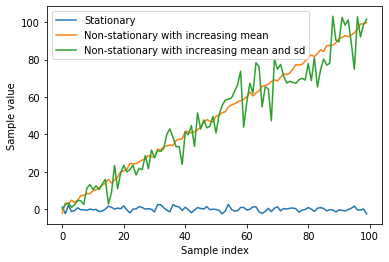

In [ ]:
# generate 100 random samples for both stationary and non-stationary distribution
T = 100
stationary_list, nonstationary_list1, nonstationary_list2 = [], [], []

for i in range(T):
    # generate a stationary sample and append to list
    stationary_list.append(generate_normal_sample([0,1]))
    # generate a non-stationary sample with an increasing mean and append to list
    nonstationary_list1.append(generate_normal_sample([i,1]))
    # # generate a non-stationary sample with an increasing mean and sd and append to list
    nonstationary_list2.append(generate_normal_sample([i,np.sqrt(i)]))

x = range(T)
# plot the lists as line plots with labels for each line
plt.plot(x, stationary_list, label='Stationary')
plt.plot(x, nonstationary_list1, label='Non-stationary with increasing mean')
plt.plot(x, nonstationary_list2, label='Non-stationary with increasing mean and sd')

# set the axis labels
plt.xlabel('Sample index')
plt.ylabel('Sample value')
# add a legend
plt.legend()
# show the plot
plt.show()

In [ ]:
# test for stationarity
def stationarity_test(x, threshold=0.05):
    """
    input: 
      x: a list of scalar values
      threshold: significance level
    output: print out message on stationarity
    """
    pvalue = adfuller(x)[1]
    if pvalue < threshold:
        return 'p-value is ' + str(pvalue) + '. The series is likely stationary.'
    else:
        return 'p-value is ' + str(pvalue) + '. The series is likely non-stationary.'

In [ ]:
print(stationarity_test(stationary_list))
print(stationarity_test(nonstationary_list1))
print(stationarity_test(nonstationary_list2))

p-value is 1.2718058919122438e-12. The series is likely stationary.
p-value is 0.9925665941220737. The series is likely non-stationary.
p-value is 0.9120355459829741. The series is likely non-stationary.


# Test for cointegration

In [ ]:
# download data from yfinance
start_date  = "2022-01-01"
end_date  = "2022-12-31"
stocks = ['GOOG','MSFT']
df = yf.download(stocks, start=start_date, end=end_date)['Adj Close']
df.head()

[*********************100%***********************]  2 of 2 completed


,GOOG,MSFT
Date,,
2022-01-03,145.074493,330.813873
2022-01-04,144.416504,325.141357
2022-01-05,137.653503,312.659882
2022-01-06,137.550995,310.189240
2022-01-07,137.004501,310.347412


In [ ]:
# build linear regression model
# Extract prices for two stocks of interest
# target var: Y; predictor: X
Y = df[stocks[0]]
X = df[stocks[1]]

# estimate linear regression coefficients of stock1 on stock2
X_with_constant = sm.add_constant(X)
model = OLS(Y, X_with_constant).fit()
residuals = Y - model.predict()

In [ ]:
# access model weights
print(model.params)

const   -47.680216
MSFT      0.610303
dtype: float64


In [ ]:
# alternative approach
residuals2 = Y - (model.params['const'] + model.params[stocks[1]] * X)
# check if both residuals are the same
print(residuals.equals(residuals2))

True


In [ ]:
# test residuals for stationarity
adf_test = adfuller(residuals)
print(f"ADF test statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

if adf_test[1] < 0.05:
    print("The two stocks are cointegrated.")
else:
    print("The two stocks are not cointegrated.")

ADF test statistic: -3.17980106932811
p-value: 0.021184049907094805
The two stocks are cointegrated.


# Cointegration and correlation

<AxesSubplot:>

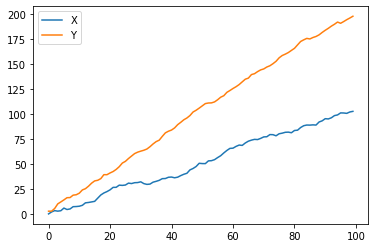

In [ ]:
np.random.seed(123)
X = np.random.normal(1, 1, 100)
Y = np.random.normal(2, 1, 100)

X = pd.Series(np.cumsum(X), name='X')
Y = pd.Series(np.cumsum(Y), name='Y')

pd.concat([X, Y], axis=1).plot()

In [ ]:
from statsmodels.tsa.stattools import coint
# calculate the correlation coefficeint
print('Correlation: ' + str(X.corr(Y)))
# perform in cointegration test
score, pvalue, _ = coint(X,Y)
print('Cointegration test p-value: ' + str(pvalue))

Correlation: 0.994833254077976
Cointegration test p-value: 0.17830098966789126


# Implement pairs trading

In [ ]:
# download data from yfinance
stocks = ['GOOG','MSFT','AAPL','TSLA','META','NFLX']
df = yf.download(stocks, start=start_date, end=end_date)['Adj Close']
df.head()

[*********************100%***********************]  6 of 6 completed


,AAPL,GOOG,META,MSFT,NFLX,TSLA
Date,,,,,,
2022-01-03,180.683868,145.074493,338.540009,330.813843,597.369995,399.926666
2022-01-04,178.390717,144.416504,336.529999,325.141357,591.150024,383.196655
2022-01-05,173.645523,137.653503,324.170013,312.659882,567.520020,362.706665
2022-01-06,170.746826,137.550995,332.459991,310.189270,553.289978,354.899994
2022-01-07,170.915573,137.004501,331.790009,310.347382,541.059998,342.320007


## Perform cointegration test

In [ ]:
from itertools import combinations

# get all pairs of stocks
stock_pairs = list(combinations(df.columns, 2))
stock_pairs

[('AAPL', 'GOOG'),
 ('AAPL', 'META'),
 ('AAPL', 'MSFT'),
 ('AAPL', 'NFLX'),
 ('AAPL', 'TSLA'),
 ('GOOG', 'META'),
 ('GOOG', 'MSFT'),
 ('GOOG', 'NFLX'),
 ('GOOG', 'TSLA'),
 ('META', 'MSFT'),
 ('META', 'NFLX'),
 ('META', 'TSLA'),
 ('MSFT', 'NFLX'),
 ('MSFT', 'TSLA'),
 ('NFLX', 'TSLA')]

In [ ]:
threshold = 0.1
# run Engle-Granger test for cointegration on each pair of stocks
for pair in stock_pairs:
    # subset df based on current pair of stocks
    df2 = df[list(pair)]
    # perform test for the current pair of stocks
    score, pvalue, _ = coint(df2.values[:,0], df2.values[:,1])
    # check if the current pair of stocks is cointegrated
    if pvalue < threshold:
        print(pair, 'are cointegrated')
    else:
        print(pair, 'are not cointegrated')

('AAPL', 'GOOG') are not cointegrated
('AAPL', 'META') are not cointegrated
('AAPL', 'MSFT') are not cointegrated
('AAPL', 'NFLX') are not cointegrated
('AAPL', 'TSLA') are not cointegrated
('GOOG', 'META') are not cointegrated
('GOOG', 'MSFT') are cointegrated
('GOOG', 'NFLX') are not cointegrated
('GOOG', 'TSLA') are not cointegrated
('META', 'MSFT') are not cointegrated
('META', 'NFLX') are not cointegrated
('META', 'TSLA') are not cointegrated
('MSFT', 'NFLX') are not cointegrated
('MSFT', 'TSLA') are not cointegrated
('NFLX', 'TSLA') are not cointegrated


## Obtain spread series

<AxesSubplot:xlabel='Date'>

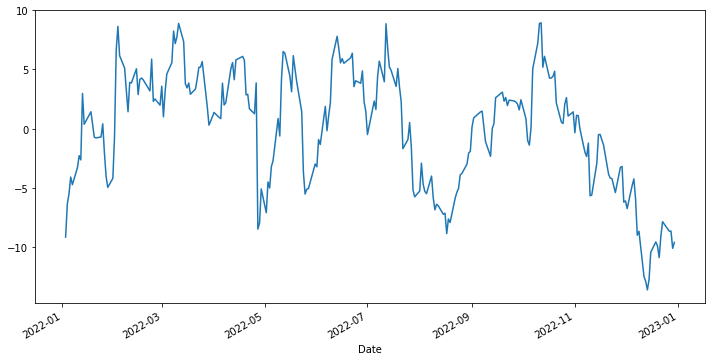

In [ ]:
# calculate the spread for GOOG and MSFT
Y = df["GOOG"]
X = df["MSFT"]
# estimate linear regression coefficients
X_with_constant = sm.add_constant(X)
model = OLS(Y, X_with_constant).fit()
# obtain the spread as the residuals
spread = Y - model.predict()
spread.plot(figsize=(12,6))

## Converting to z-scores

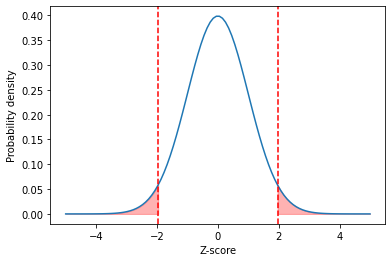

In [ ]:
# illustrate z score by generating a standard normal distribution with mu 0 and sd 1
from scipy.stats import norm
# input: unbounded scalar, assumed to be in the range of [-5,-5] in this case
x = np.linspace(-5, 5, 100)
# output: probability between 0 and 1
y = norm.pdf(x, loc=0, scale=1)
# set up the plot
fig, ax = plt.subplots()
# plot the pdf of normal distribution
ax.plot(x, y)
# shade the area corresponding to a z-score of >=1.96 and <=-1.96
z_critical = 1.96
x_shade = np.linspace(z_critical, 5, 100)
y_shade = norm.pdf(x_shade, loc=0, scale=1)
ax.fill_between(x_shade, y_shade, color='red', alpha=0.3)
z_critical2 = -1.96
x_shade2 = np.linspace(-5, z_critical2, 100)
y_shade2 = norm.pdf(x_shade2, loc=0, scale=1)
ax.fill_between(x_shade2, y_shade2, color='red', alpha=0.3)
# add labels and a title
ax.set_xlabel('Z-score')
ax.set_ylabel('Probability density')
# add a vertical line to indicate the z-score of 1.96 and -1.96
ax.axvline(x=z_critical, linestyle='--', color='red')
ax.axvline(x=z_critical2, linestyle='--', color='red')
# display the plot
plt.show()

<AxesSubplot:xlabel='Date'>

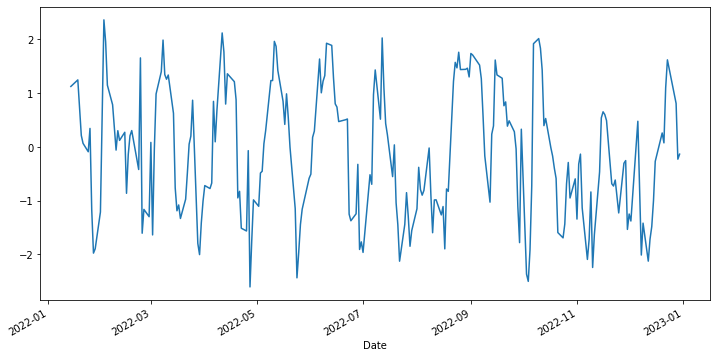

In [ ]:
# convert to z score
# z-score is a measure of how many standard deviations the spread is from its mean
# derive mean and sd using a moving window
window_size = 10
spread_mean = spread.rolling(window=window_size).mean()
spread_std = spread.rolling(window=window_size).std()
zscore = (spread - spread_mean) / spread_std
zscore.plot(figsize=(12,6))

In [ ]:
# remove initial days with NA
first_valid_idx = zscore.first_valid_index()
zscore = zscore[first_valid_idx:]

In [ ]:
zscore

Date
2022-01-14    1.123745
2022-01-18    1.245482
2022-01-19    0.742027
2022-01-20    0.211880
2022-01-21    0.064884
                ...   
2022-12-23    1.618937
2022-12-27    0.977235
2022-12-28    0.807607
2022-12-29   -0.230086
2022-12-30   -0.137035
Name: GOOG, Length: 242, dtype: float64

## Formulating trading strategy

In [ ]:
# set the threshold values for entry and exit signals
entry_threshold = 2.0
exit_threshold = 1.0
# initialize the daily positions to be zeros
stock1_position = pd.Series(data=0, index=zscore.index)
stock2_position = pd.Series(data=0, index=zscore.index)
# generate daily entry and exit signals for each stock
for i in range(1, len(zscore)):
    # zscore<-2 and no existing long position for stock 1
    if zscore[i] < -entry_threshold and stock1_position[i-1] == 0:
        stock1_position[i] = 1 # long stock 1
        stock2_position[i] = -1 # short stock 2
    # zscore>2 and no existing short position for stock 2
    elif zscore[i] > entry_threshold and stock2_position[i-1] == 0:
        stock1_position[i] = -1 # short stock 1
        stock2_position[i] = 1 # long stock 2
    # -1<zscore<1
    elif abs(zscore[i]) < exit_threshold:
        stock1_position[i] = 0 # exit existing position
        stock2_position[i] = 0
    # -2<zscore<-1 or 1<zscore<2
    else:
        stock1_position[i] = stock1_position[i-1] # maintain existing position
        stock2_position[i] = stock2_position[i-1]

<AxesSubplot:xlabel='Date'>

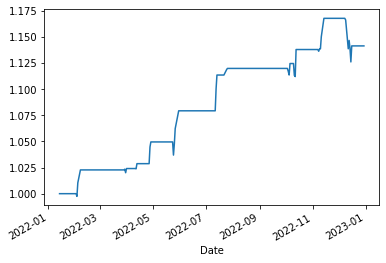

In [ ]:
# Calculate the returns of each stock
stock1_returns = (df["GOOG"][first_valid_idx:].pct_change() * stock1_position.shift(1)).fillna(0)
stock2_returns = (df["MSFT"][first_valid_idx:].pct_change() * stock2_position.shift(1)).fillna(0)
# calculate the total returns of the strategy
total_returns = stock1_returns + stock2_returns
cumulative_returns = (1 + total_returns).cumprod()
# plot the cumulative returns
cumulative_returns.plot()

In [ ]:
# terminal return
cumulative_returns[-1] - 1

0.14137116410086725